# 1. Import the relevant libraries and packages

First I need to import all the relevant libraries and packages that will allow me to perform sentiment analysis and to visualise the results.

The most commonly-used packages can be imported with the following lines of code.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from afinn import Afinn
import wordcloud as wc

# 2. Modify the library and package settings

With the following code cell, you can set the colours and palettes for the seaborn graphing package that you imported in the previous step.

In [2]:
pred = '#e63635'
pgrey = '#3c3f41'
mgrey = '#b2b3b3'
lgrey = '#edebeb'
purp = '#ab66cc'
amet = '#8371e2'
turq = '#7ce6d8'
blue = '#55acee'
whit = '#ffffff'

# Define a colour palette
LSEpalt1 = [pred, pgrey, purp, amet]
LSEpalt2 = [pred, purp, turq, blue]
LSEpalt3 = [pred, purp, turq, amet, blue]

**IMPORTANT:** To ensure that the results are consistent (no matter how many times you perform or run the analysis), it is important to set a random number seed, which ensures better replicability. 

In [3]:
random.seed(6437)

# 3. Importing, reading, and checking the data file

With the relevant libraries and packages successfully imported, the next step is to import the data file and ensure that the data loads correctly. In this case, you will import a .json data file titled "m4u3.json", which is a collection of Yelp reviews.

In [4]:
# You will start by creating an empty dataframe with the columns alone.

ylp1 = pd.DataFrame(columns = ["review_id", "user_id", "business_id", "stars", "date", "text", "useful", "funny", "cool"])

In [5]:
# You will then read the .json data file.

i = 1
with open("Retail Sentiment Analysis JSON", 'r', encoding="utf8") as file1:
    for jline in file1:
        dct1 = json.loads(jline)
        a = pd.DataFrame.from_dict(dct1, orient='index')
        ylp1 = ylp1.append(a.T, ignore_index=True)

        i= i + 1

In [6]:
# What does the file look like? 

print(" shape of ylp1 ", ylp1.shape )

 shape of ylp1  (3000, 9)


In [7]:
# After this command you should see that there are 3000 rows and 9 columns in the data set.
# To further validate the data set, you can pick a particular review - for example, the 85th review - and see what it says.

print("ylp1.text[85], as an example")
print(ylp1.text[85])

ylp1.text[85], as an example
Best real Turkish iskender doner kebab ,fantastic baklava and Turkish tea, nice management in Danforth .


In [8]:
# Next, you can check for the star-rating for this particular review.

print("stars for ylp1.text[85]")
print(ylp1["stars"][85])

stars for ylp1.text[85]
5


# 3. Cleaning the data

If I were to explore the data set manually, I would notice that the reviews often contain extra spaces and orphaned periods. This is evident in the 85th review that I extracted from the data set. 

The following lines of code will allow me to clean the data set, removing these extra spaces and correcting the orphaned periods.

In [9]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
REPLACE_ISO_DIGITS = re.compile(r'\b\d+\b')  ## for isolated digits
REPLACE_ALL_DIGITS = re.compile(r'\d*')      ## for all digits
REPLACE_ALL_2SPACES = re.compile(r'\s\s+')   ## for multiple spaces

def preprocess_text(txt):
    clean_txt = REPLACE_NO_SPACE.sub("", txt.lower())
    clean_txt = REPLACE_WITH_SPACE.sub(" ", clean_txt)
    clean_txt = REPLACE_ISO_DIGITS.sub("", clean_txt)
    clean_txt = REPLACE_ALL_DIGITS.sub("", clean_txt)
    clean_txt = REPLACE_ALL_2SPACES.sub(" ", clean_txt)
    return clean_txt


In [10]:
print(ylp1.info())
ylp1['txt_wip'] = ylp1['text'].apply(lambda x: preprocess_text(x))
print(ylp1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    3000 non-null   object
 1   user_id      3000 non-null   object
 2   business_id  3000 non-null   object
 3   stars        3000 non-null   object
 4   date         3000 non-null   object
 5   text         3000 non-null   object
 6   useful       3000 non-null   object
 7   funny        3000 non-null   object
 8   cool         3000 non-null   object
dtypes: object(9)
memory usage: 211.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    3000 non-null   object
 1   user_id      3000 non-null   object
 2   business_id  3000 non-null   object
 3   stars        3000 non-null   object
 4   date         3000 non-null   object
 5

In [11]:
# You can validate what this cleaning does for the 85th review.

print("ylp1.text_wip[85] after preprocess_text")
print(ylp1.txt_wip[85])

ylp1.text_wip[85] after preprocess_text
best real turkish iskender doner kebab fantastic baklava and turkish tea nice management in danforth 


Once you have confirmed that the data has been cleaned effectively, the next steps involve checking for possible data corruption.

# 4. Data corruption and formatting

To assess whether any of the data is corrupt, I can generate descriptive statistics for the review star-rating and observe whether there are any outliers that don't make sense. Before doing this, it's important to ask yourself what kind of numbers you expect to see in the data set.

In [12]:
ylp1['stars'].describe()

count     3000
unique       5
top          5
freq      1132
Name: stars, dtype: int64

Why is this output unexpected, and what does this say about how the data might be formatted?

The easiest way to correct any formatting issues is to change the variable type to "float", which is achieved with the following lines of code.

In [13]:
ylp1['stars'] = ylp1['stars'].apply(lambda x: float(x))
ylp1['stars'].describe()

count    3000.000000
mean        3.764000
std         1.305963
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: stars, dtype: float64

You can do the same with the variables "useful", "funny", and "cool".

In [14]:
ylp1['useful'] = ylp1['useful'].apply(lambda x: float(x))
ylp1['funny'] = ylp1['funny'].apply(lambda x: float(x))
ylp1['cool'] = ylp1['cool'].apply(lambda x: float(x))

# 5. Remove stop words

Next, it's important to remove the background noise within the reviews. To do this, I will remove "stop words", which are common, small words that occur in abundance within text (such as "the", "he", "she" etc.). 

This can be done because the removal of stop words would not lead to any loss of meaning within the review. 

In [15]:
english_stop_words = stopwords.words('english')

def remove_stop_words(txt):
    clean_txt = []
    clean_txt.append(
        ' '.join([word for word in txt.split() 
                  if word not in english_stop_words])
    )
    str1 = " "   # to convert list with 1 string back to string
    clean_txt = str1.join(clean_txt)
    return clean_txt

ylp1['txt_wip'] = ylp1['txt_wip'].apply(lambda x: remove_stop_words(x))

In [16]:
# Once again, you can look at the 85th review and assess how it appears without stop words.

print("ylp1.text_wip[85] after stopwords processing")
ylp1.txt_wip[85]

ylp1.text_wip[85] after stopwords processing


'best real turkish iskender doner kebab fantastic baklava turkish tea nice management danforth'

Next, you will move on to the process of lemmatisation (or normalisation). 

# 6. Lemmatisation

Lemmatisation is the process of grouping together variants of words that essentially have similar meanings (for example, the words "love" and "loving" could be grouped together, given their almost identical meanings). 

**NOTE:** The process of "stemming" is another technqiue that's also used quite often to help normalise words (although it's a much cruder technique compared to lemmatisation)

In [17]:
def lemmatiz_text(txt):
    lemmatizer = WordNetLemmatizer()
    clean_txt = [' '.join([lemmatizer.lemmatize(word) for word in txt.split()])]
    str1 = " "   # to convert list with 1 string back to string
    clean_txt = str1.join(clean_txt)
    return clean_txt

In [18]:
ylp1['txt_wip'] = ylp1['txt_wip'].apply(lambda x: lemmatiz_text(x))

In [19]:
# Again, you can confirm this word normalisation by assessing the 85th review once again.

print("ylp1.text_wip[85] after lemmatization")
ylp1.txt_wip[85]

ylp1.text_wip[85] after lemmatization


'best real turkish iskender doner kebab fantastic baklava turkish tea nice management danforth'

# 7. Sentiment analysis at the level of the customer review

Now that I have flexibility to study the words used individually, at the level of each review, and across the entire data set, I can move on to scoring words in terms of the sentiment (or emotion) they represent. 

To do this, I used the AFINN Sentiment Lexicon of emotions to help score each of the words in the reviews. This lexicon ascribes a valence to words (with the most negative words being assigned a value of -5 and the most positive words being assigned a +5). This is achieved with the following lines of code.

In [20]:
# We invoke the AFINN dictionary of emotions to score these words.

af = Afinn()

In [21]:
# Get the review score.

ylp1['lx1_review_score'] = ylp1['txt_wip'].apply(lambda x: af.score(x))

In [22]:
# Get the length of the text

ylp1['wordlen'] = ylp1['txt_wip'].apply(lambda x: len(x.split()))

# Get the average review score
# NOTE: This average is different from building it from word up.
# The number of words with scores = len(af.scores(ylp1['txt_wip'][85]))

ylp1['lx1_avg_rev_score'] = ylp1['lx1_review_score']/ylp1['wordlen']

To summarise what I have done thus far: I have scored each word for its sentiment using the AFINN lexicon. The lower the score, the more negative the sentiment (with scores ranging between -5 and +5). I then affixed those scores to each word in the review and generated an average of those scores to give the sentiment score of that specific review as a whole (rather than individual words). 

As a next step, I could always look at those sentiment scores in a descriptive manner and observe how negative or positive the reviews are. However, why is this not necessarily a meaningful approach? What could be done instead to address these problems?

I begin with a simple analysis of the data using a bivariate jitter plot. For this chart, I will plot the AFINN sentiment scores against the 1–5 star ratings (where 1 = poor and 5 = excellent). 

Before running the code, try and predict what pattern you might expect to see.

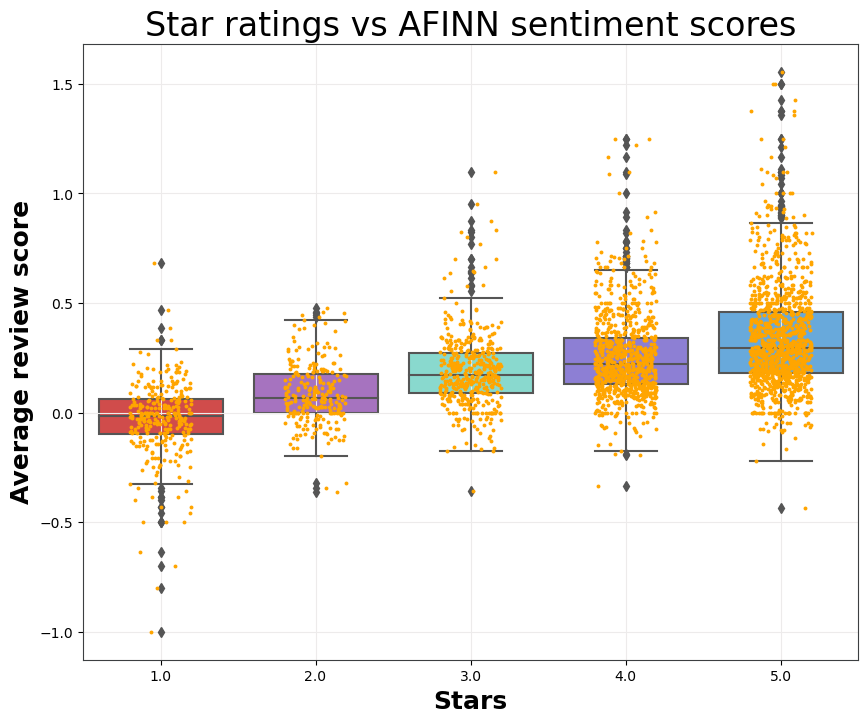

In [23]:
# Jitter Plot of Sentiment Score vs. 1-5 Star Ratings
ax=plt.figure(figsize=(10,8))
ax = sns.boxplot(x='stars', y='lx1_avg_rev_score', data=ylp1, palette=LSEpalt3)
ax = sns.stripplot(x='stars', y='lx1_avg_rev_score', data=ylp1, color="orange", jitter=0.2, size=2.8)

ax.spines['bottom'].set_color(pgrey)
ax.spines['left'].set_color(pgrey)
ax.spines['top'].set_color(pgrey)
ax.spines['right'].set_color(pgrey)
ax = ax.set_facecolor('#ffffff'), ax.grid(color=lgrey, linestyle='-')
plt.title("Star ratings vs AFINN sentiment scores", loc="center", size=24)
plt.xlabel('Stars', size=18, fontweight='bold')
plt.ylabel('Average review score', size=18, fontweight='bold')
plt.show()

From the plot, I deduced that there is some truth to the data. The AFFIN dictionary is working well.(Upward sloppy movement) The average review score of the AFFIN is propotional to the customer sentiment and ratings. Reviews that have been scored lower on the AFFIN dictionary seem to be getting a 1 star and the reviews that have scored higher seem to be getting 5 stars. However, there are areas of concern showing outliers (black dots)that are not well caliberated by the AFFIN sentiment scores. In other words, the AFFIN thinks that some customers had a good experience but rated the business low and vice versa. Also, there are words the AFFIN is not able to capture appropriately. Hence, we need to change the dictionary to a more sophiscated one known as the Vader Lexicon. It is known to be able to handle contextual sentiments, capture intensity, abbreviations and even emojis.

# 8. Using a second dictionary: the Vader lexicon

An alternative strategy could be to change the lexicon or dictionary that is used to score sentiment. In this section, instead of using the AFINN lexicon, I will shift to using the Vader Lexicon (**V**alence **A**ware **D**ictionary for s**E**ntiment **R**easoning Lexicon), which is a more recent and advanced lexicon. 

In [24]:
# First, you can invoke the dictionary. 

analyzer = SentimentIntensityAnalyzer()

# The polarity_scores method returns a dictionary with four items.

print(" analyzer.polarity_scores for ylp1.text_wip[85]")
print(analyzer.polarity_scores(ylp1['txt_wip'][85]))
# pos, neu, and neg are the proportions of text that fall in each category, whereas compound is the normalized, weighted composite score.

# One useful feature of Vader is that it is able to look at works in context and score appropriately.

print("analyzer.polarity_scores for 'At least it isn't a horrible restaurant.' ")
print(analyzer.polarity_scores("At least it isn't a horrible restaurant."))

print("analyzer.polarity_scores for 'At least it is a horrible restaurant.' ")
print(analyzer.polarity_scores("At least it is a horrible restaurant."))

# It also scores contemporary lingo and emojis.

print("analyzer.polarity_scores for 'Food SUX' ")
print(analyzer.polarity_scores('Food SUX!'))

print("analyzer.polarity_scores for '💋' ")
print(analyzer.polarity_scores('💋'))

print("analyzer.polarity_scores for ' :) ' ")
print(analyzer.polarity_scores(' :) '))

# Now, get the review scores including the one for review 85.

ylp1['lx2_review_score_dict'] = ylp1['txt_wip'].apply(lambda x: analyzer.polarity_scores(x))
print(" ylp1['lx2_review_score_dict'][85]")
print(ylp1['lx2_review_score_dict'][85])

# Use the "compound" value as the score.

ylp1['lx2_review_score'] = ylp1['lx2_review_score_dict'].apply(lambda x: x['compound'])
print(" ylp1['lx2_review_score'][85], the compound part")
print(ylp1['lx2_review_score'][85])

 analyzer.polarity_scores for ylp1.text_wip[85]
{'neg': 0.0, 'neu': 0.485, 'pos': 0.515, 'compound': 0.891}
analyzer.polarity_scores for 'At least it isn't a horrible restaurant.' 
{'neg': 0.0, 'neu': 0.637, 'pos': 0.363, 'compound': 0.431}
analyzer.polarity_scores for 'At least it is a horrible restaurant.' 
{'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'compound': -0.5423}
analyzer.polarity_scores for 'Food SUX' 
{'neg': 0.779, 'neu': 0.221, 'pos': 0.0, 'compound': -0.5461}
analyzer.polarity_scores for '💋' 
{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
analyzer.polarity_scores for ' :) ' 
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4588}
 ylp1['lx2_review_score_dict'][85]
{'neg': 0.0, 'neu': 0.485, 'pos': 0.515, 'compound': 0.891}
 ylp1['lx2_review_score'][85], the compound part
0.891


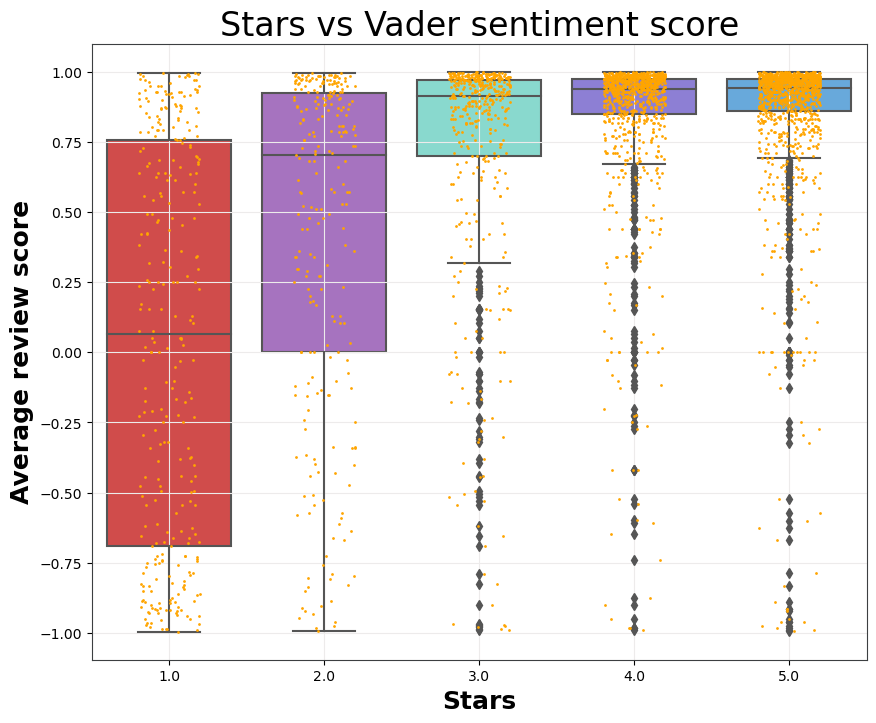

In [25]:
# Now, create a jitter plot of the Vader sentiment scores versus the 1-5 star ratings.
ax=plt.figure(figsize=(10,8))
ax = sns.boxplot(x='stars', y='lx2_review_score', data=ylp1, palette=LSEpalt3)
ax = sns.stripplot(x='stars', y='lx2_review_score', data=ylp1, color="orange", jitter=0.2, size=2.0)

ax.spines['bottom'].set_color(pgrey)
ax.spines['left'].set_color(pgrey)
ax.spines['top'].set_color(pgrey)
ax.spines['right'].set_color(pgrey)
ax = ax.set_facecolor('#ffffff'), ax.grid(color=lgrey, linestyle='-')
plt.title("Stars vs Vader sentiment score", loc="center", size=24)
plt.xlabel('Stars', size=18, fontweight='bold')
plt.ylabel('Average review score', size=18, fontweight='bold')
plt.show()

From this plot, I can deduce that from the middle points in the box plots, we can see that as the vader sentiment score starts increasing, we can see an upward slope. But we can also see that there are words customers are using in specific manners that the vader lexicn cant make sense of.E.g Bunch of words the vader lexicon scores -0.75 and -1.00 but the black dots under the 5 stars under the box plots indicates that there are words people are using to make positive and delightful sentiments. E.g a customer using "die" in the context of "this dessert was to die for" and somehow vader is unable to capture the essence of that sentiment.

Next, I will take a closer look at the individual words that make up the reviews and assess how these were scored in order to spot these kinds of anomalies. To do this, I will perform sentiment analysis at the word-level, as opposed to the review-level.

# 9. Sentiment analysis at the word level with the unnest (or explode) function

I will now use the **unnest** function, which provides me with the flexibility of looking at each word (within a review) that is meaningful on its own. This has the advantage of allow you to score each word in terms of its indicative sentiment and to tie back that meaning to the original review. In short, this allows me to break up a review into a list of words (i.e. "unnesting" the review) to score those words in a meaningful way, and to assign those scores to the review in its entirety (i.e. "nesting" the scores).

In [26]:
print(" before converting the text to a list of words ", dt.now() )
ylp1['txt_list'] = ylp1['txt_wip'].apply(lambda x: x.split())
print(" before exploding the list of words ", dt.now() )
ylp2 = ylp1[["review_id","business_id","stars","txt_list","lx1_avg_rev_score","lx2_review_score"]].explode("txt_list")
print(" ylp2 shape= ", ylp2.shape, " at ", dt.now() )

# Rename the exploded column and the score columns
ylp2 = ylp2.rename(
{ 'txt_list':'word'
, 'lx1_avg_rev_score':'Afinn_score'
, 'lx2_review_score':'Vader_score'}
, axis=1)


 before converting the text to a list of words  2023-05-06 12:46:06.539711
 before exploding the list of words  2023-05-06 12:46:06.552006
 ylp2 shape=  (183256, 6)  at  2023-05-06 12:46:06.587110


In [27]:
ylp2_agg = ylp2.groupby('word').agg(
{ 'review_id': ['nunique']
, 'business_id': ['nunique']
, 'stars': ['sum', 'mean']
, 'Afinn_score': ['mean']
, 'Vader_score': ['mean']
# , 'xxxx': ['count', 'mean', 'nunique']
}).reset_index()
ylp2_agg.columns = ["_".join(x) for x in ylp2_agg.columns.ravel()]




# Analysis below to show stars_mean is a better metric than stars_sum

print("\n")
print("\n")
print(" statistics for ylp2_agg.stars_sum")
print( ylp2_agg.stars_sum.describe() )
#  median << mean, Right skewed; but std=150 !!!! , some real big outliers

# Check percentiles
np.percentile(ylp2_agg.stars_sum,  5)   ##  1.0
np.percentile(ylp2_agg.stars_sum, 10)   ##  2.0
np.percentile(ylp2_agg.stars_sum, 15)   ##  3.0
np.percentile(ylp2_agg.stars_sum, 35)   ##  4.0
np.percentile(ylp2_agg.stars_sum, 60)   ##  9.0
np.percentile(ylp2_agg.stars_sum, 70)   ## 13.0
np.percentile(ylp2_agg.stars_sum, 80)   ## 24.0
np.percentile(ylp2_agg.stars_sum, 90)   ## 68.0


print("\n")
print("\n")
print(" statistics for ylp2_agg.stars_mean")
print( ylp2_agg.stars_mean.describe() )
## well distributed


print("\n")
print("\n")
print(" ylp2_agg sorted by stars_sum")
print( ylp2_agg.sort_values(by=['stars_sum'], ascending=False)[['word_', 'stars_sum','stars_mean']].head(10) )


print("\n")
print("\n")
print(" ylp2_agg sorted by stars_mean,stars_sum")
print( ylp2_agg.sort_values(by=['stars_mean', 'stars_sum'], ascending=False)[['word_', 'stars_sum','stars_mean']].head(10) )


print("\n")
print("\n")
print(" ylp2_agg sorted by review_id_nunique,stars_mean,stars_sum")
print( ylp2_agg.sort_values(by=['review_id_nunique','stars_mean','stars_sum'], ascending=False)[['word_','review_id_nunique', 'stars_sum','stars_mean']].head(10) )


print("\n")
print("\n")
print(" ylp2_agg sorted by business_id_nunique,stars_mean,stars_sum")
print( ylp2_agg.sort_values(by=['business_id_nunique','stars_mean','stars_sum'], ascending=False)[['word_','business_id_nunique', 'stars_sum','stars_mean']].head(10) )


print("\n")
print("\n")
print(" Filter out words as per analysis")
# Based on analysis above, zoom in on the most relevant words
# Some assumptions required, like word length


# First remove observed weird characters (to be included in preprocessing in next iteration)
ylp2_agg['word_'] = ylp2_agg['word_'].map(lambda x: re.sub(r'\W+', '', x))


# Specify minimum word length to look at
v_minlen = 4
print("minimum word length to keep= ", v_minlen)

# Filter by this minimum
print(" rows before filtering by v_minlen = ", ylp2_agg.shape[0])
ylp2_agg = ylp2_agg[ylp2_agg['word_'].map(lambda x: len(x)) >= v_minlen]
print(" rows after filtering by v_minlen = ", ylp2_agg.shape[0])


# Stopwords extension, based on what was seen
stopwords_2 = ['food', 'place', 'burger', 'time', 'castle', 'service'
, 'slider', 'back', 'really', 'would', 'also', 'little', 'vega', 'come'
, 'chicken', 'order', 'cheese', 'restaurant', 'even', 'price', 'definitely'
, 'three', 'four', 'five', 'seven', 'eight', 'nine', 'eleven', 'twelve'
, 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty' 
, 'ninety', 'hundrend', 'thousand', 'million', 'elite', 'dylan'
, 'installed', 'receiver', 'mounted', 'wire', 'fyitm', 'surround'
, 'cable', 'demi', 'dental', 'dentist', 'ashley', 'craig', 'miso'
, 'mount', 'pilot', 'wiring', 'automation', 'professionally', 'ordered'
, 'people', 'going', 'came'
]

ylp2_agg = ylp2_agg[~ylp2_agg['word_'].isin(stopwords_2)]






 statistics for ylp2_agg.stars_sum
count    13217.000000
mean        50.014829
std        241.160797
min          1.000000
25%          4.000000
50%          5.000000
75%         17.000000
max       6063.000000
Name: stars_sum, dtype: float64




 statistics for ylp2_agg.stars_mean
count    13217.000000
mean         3.486699
std          1.164629
min          1.000000
25%          3.000000
50%          3.718750
75%          4.200000
max          5.000000
Name: stars_mean, dtype: float64




 ylp2_agg sorted by stars_sum
       word_  stars_sum  stars_mean
11726   time     6063.0    3.724201
4932     get     5925.0    3.698502
9666    ride     5612.0    3.960480
5151   great     5348.0    4.220994
12481   view     5165.0    3.966974
8040     one     4520.0    3.607342
5061    good     4507.0    3.706414
5031      go     4390.0    3.692178
12363   vega     4316.0    4.157996
5525    high     4183.0    3.964929




 ylp2_agg sorted by stars_mean,stars_sum
             word_  stars_sum

In [28]:
# Next, get the most used words by reviewers and for businesses.
# This will help make sure that a few odd phrases, used by only a handful of businesses, is not driving the results.

v_min_rev = 100
v_min_biz = 10
ylp2_top = ylp2_agg[(ylp2_agg['review_id_nunique']>v_min_rev)&(ylp2_agg['business_id_nunique']>v_min_biz)]


# Next, see if the words make sense - that is, are the top most positively used words receiving the top most 1-5 star ratings?

print("\n")
print("\n")
print(" ylp2_top sorted by stars_mean,stars_sum")
print( ylp2_top.sort_values(by=['stars_mean', 'stars_sum'], ascending=False)[['word_', 'stars_sum','stars_mean']].head(10) )





 ylp2_top sorted by stars_mean,stars_sum
           word_  stars_sum  stars_mean
895      awesome     1446.0    4.449231
5532      highly      603.0    4.433824
443      amazing     1898.0    4.403712
1078   beautiful      708.0    4.370370
6906       loved      633.0    4.365517
8478     perfect      554.0    4.229008
5346       happy     1852.0    4.228311
11967       trip      875.0    4.227053
5151       great     5348.0    4.220994
9346   recommend     1478.0    4.210826


Next, I will do some analyses and create plots at the word level so that I can know what words lead to a low star rating and what words translate to a high star rating. In this way, I would be able to pre-empt what might happen (in terms of star ratings) when customers use certain words versus others. 

# 10. Word cloud

First, I will attempt to analyse the results by using a word cloud. In this plot, frequently used words will appear more prominently in the cloud relative to words that are used less frequently. 

In [29]:
text = ylp2_top['word_'].str.cat(sep=" ") ## concatenate the column

# Create and generate a word cloud image:
# wcloud = wc.WordCloud().generate(text)

v_words = 60
wcloud = wc.WordCloud(max_font_size=60, max_words=v_words, margin=10
         , random_state=123, background_color=lgrey
         , width=960, height=480, colormap="Set2").generate(text)

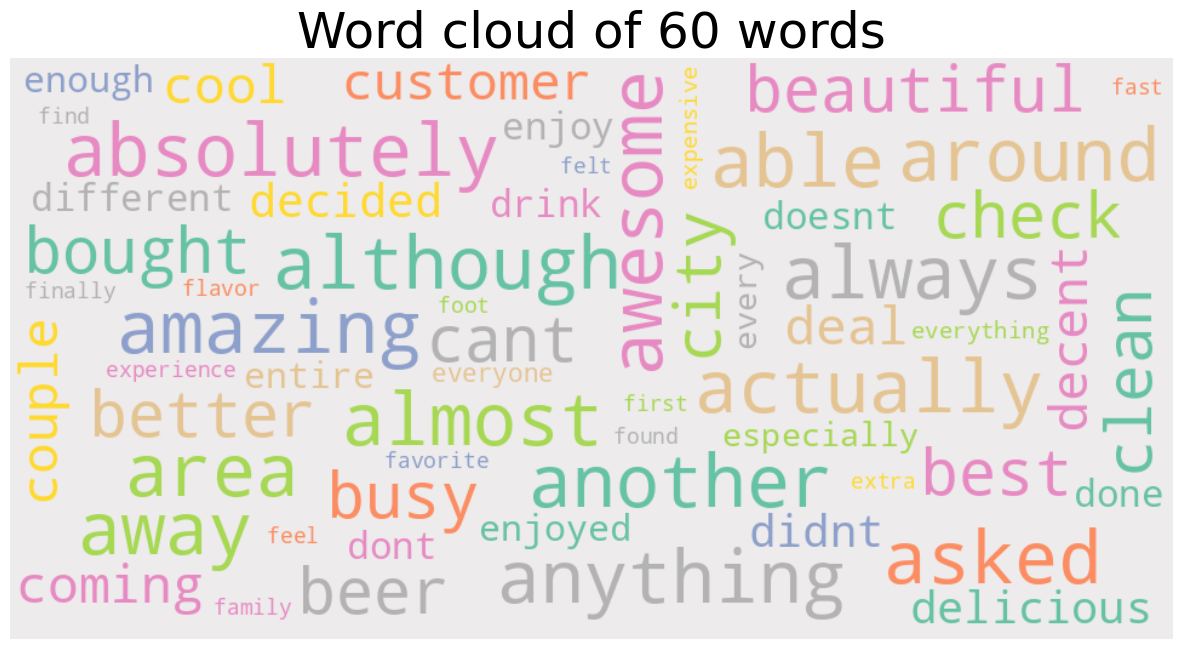

In [30]:
# Display the generated image:
ax=plt.figure(figsize=(15,10))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
v_title = "Word cloud of "+str(v_words)+" words"
plt.title(v_title, loc="center", fontsize=36)
plt.show()

When analysing the word cloud, what words emerge as significant? How might we use this analysis? Word clouds can still serve as a starting point for exploring sentiment in text data. However, they should be used in conjunction with other analysis techniques to gain a more accurate and comprehensive understanding of sentiment. It's crucial to consider the limitations of word clouds and incorporate additional approaches that account for context, sentiment intensity, and sentence/document-level sentiment analysis for more robust sentiment analysis outcomes.

# 11. Other plots

There are also other plots that I can create to further tease apart which words translate to a specific star rating, whether low or high. The first is by plotting the most frequent words sorted by their average star rating against the number of reviews that the words appear in. Plotting the top 30 words against the number of reviews and the star ratings provides insights into the frequency and popularity of specific words among reviewers. This analysis helps understand the importance or emphasis placed on certain aspects in customer reviews.

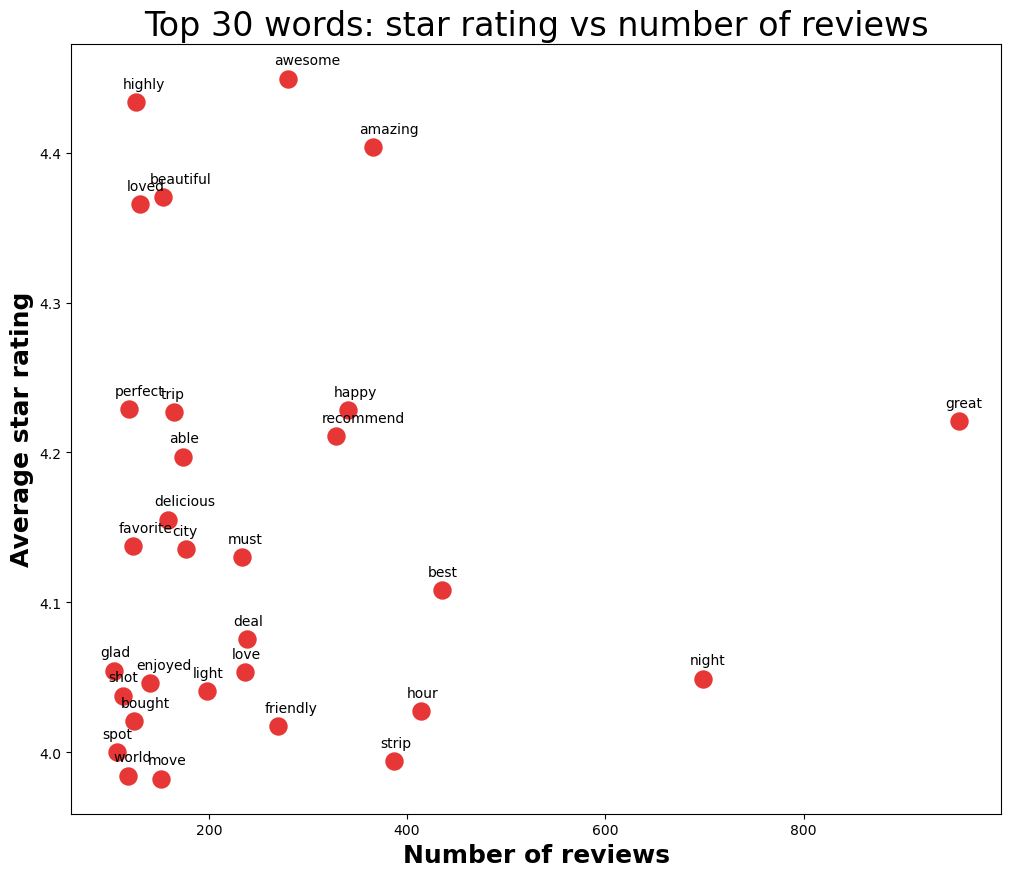

In [31]:
w1 = 30
ylp2_plot = ylp2_top.sort_values(by=['stars_mean'], ascending=False)[['word_', 'review_id_nunique','stars_mean']].head(w1)

# Plot the star ratings versus the number of reviews.

y = list(ylp2_plot.stars_mean.values)
x = list(ylp2_plot.review_id_nunique.values)
n = list(ylp2_plot.word_.values)

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(x, y, color=pred, s=150)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]), xytext=(-10,10), textcoords='offset points', ha='left')
v_title = "Top "+str(w1)+" words: star rating vs number of reviews"
plt.title(v_title, size=24)
plt.ylabel("Average star rating", size=18, fontweight='bold')
plt.xlabel("Number of reviews", size=18, fontweight='bold')
plt.show()


From this plot, I could identify how often words appear in customer reviews, with words like “great” appearing in over 800 reviews, “awesome” appearing in over 250 reviews, and “amazing” appearing in over 300 reviews with average star ratings between 4.2 and 4.4. This plot indicates that certain positive words like "great," "awesome," and "amazing" are frequently used in customer reviews. The high frequency of these words suggests that customers are expressing positive sentiments in their reviews. Additionally, the fact that these words are associated with average star ratings between 4.2 and 4.4 further supports the notion that customers who use these positive words tend to give higher ratings. It implies that customers who had positive experiences are more likely to use these words in their reviews, which can be seen as an indication of customer satisfaction.

For the second plot, I will chart the most frequent words sorted by the average star rating against the AFINN sentiment scores.Plotting the top 30 words against the sentiment scores provides insights into the sentiment expressed by reviewers for those specific words. It helps identify the overall sentiment associated with each word and can reveal patterns or trends in sentiment.

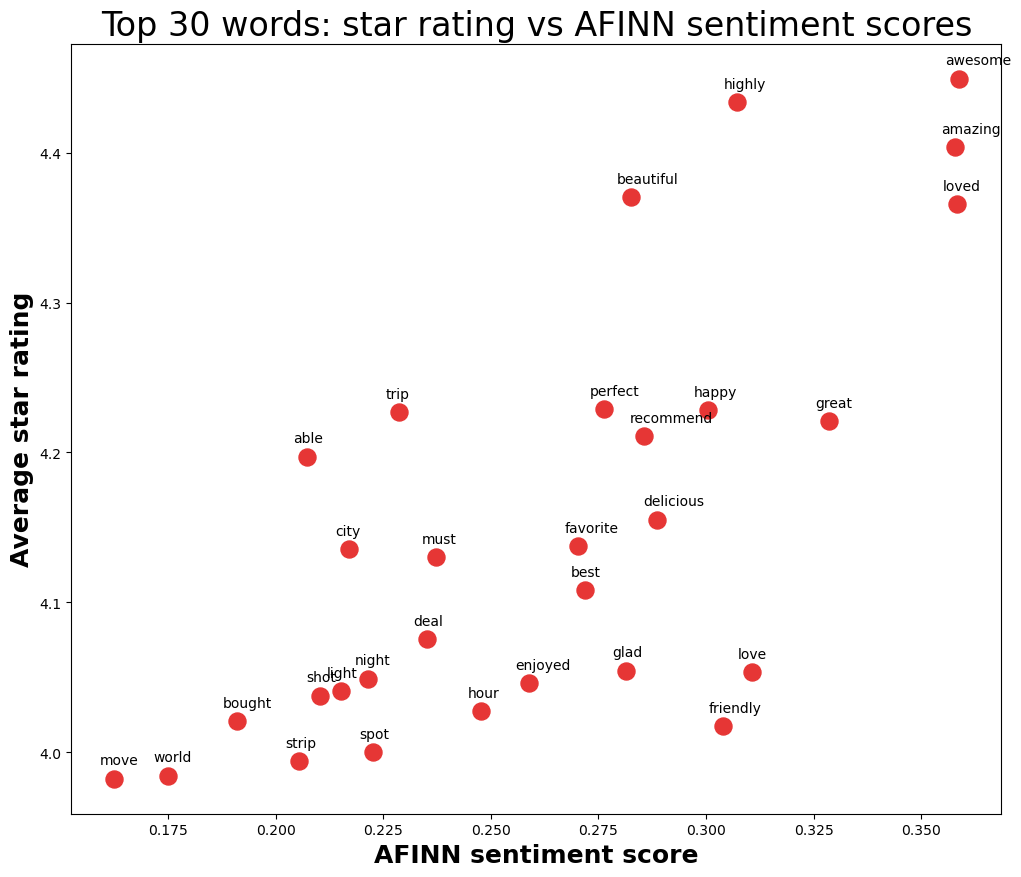

In [32]:
w1 = 30
ylp2_plot = ylp2_top.sort_values(by=['stars_mean'], ascending=False)[['word_', 'Afinn_score_mean','stars_mean']].head(w1)

#! Plot stars vs reviews
y = list(ylp2_plot.stars_mean.values)
x = list(ylp2_plot.Afinn_score_mean.values)
n = list(ylp2_plot.word_.values)

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(x, y, color=pred, s=150)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]), xytext=(-10,10), textcoords='offset points', ha='left')
v_title = "Top "+str(w1)+" words: star rating vs AFINN sentiment scores"
plt.title(v_title, size=24)
plt.ylabel("Average star rating", size=18, fontweight='bold')
plt.xlabel("AFINN sentiment score", size=18, fontweight='bold')
plt.show()

This plot improves on the previous ones in deciphering which words are associated with lower or higher star ratings by showing more importantly how I could identify which words are strongly associated with positive customer sentiment. I noticed that customer reviews containing the words “awesome”, “amazing”, “great”, "loved","highly", “beautiful”, “happy” or “perfect” are more likely to be found in positive reviews, as indicated by the high average star rating. 
In disparity, words that are strongly associated with lower AFINN scores or negative customer sentiment, such as “hour” and “night”, although not necessarily negative words, reveal potential weaknesses of the restaurants. It can be linked to unfavorable customer opinions; this may indicate that customers are not happy with how much time they spent at the establishment or with their entire experience at night. It may also indicate that a company is not offering a great experience if it is open late at night. This could be because of a variety of things, including inadequate lighting, excessive noise, or safety issues. It may also indicate that customers feel they are waiting too long or that the service is poor or inefficient. It could point to issues like understaffing, poor management, or other issues that increase wait times may be to blame for this. Consequently, managerial decisions can be made to enhance service efficiency and enhance the nighttime experience.
It's interesting to note that adjectives like "friendly," which don't necessarily refer to consumer attitudes, also stand up as advantageous qualities. It can point to the importance of delivering polite service to consumers, including hints about potential managerial choices. The business might concentrate on this to increase favorable ratings and customer satisfaction. 


There are additional plots you can use to clarify how customers experience the restaurant. For example, what are some of the most frequent words used by reviewers when giving the restaurant a high star rating? This can be visualised by plotting a set number of frequent words against the average star ratings.


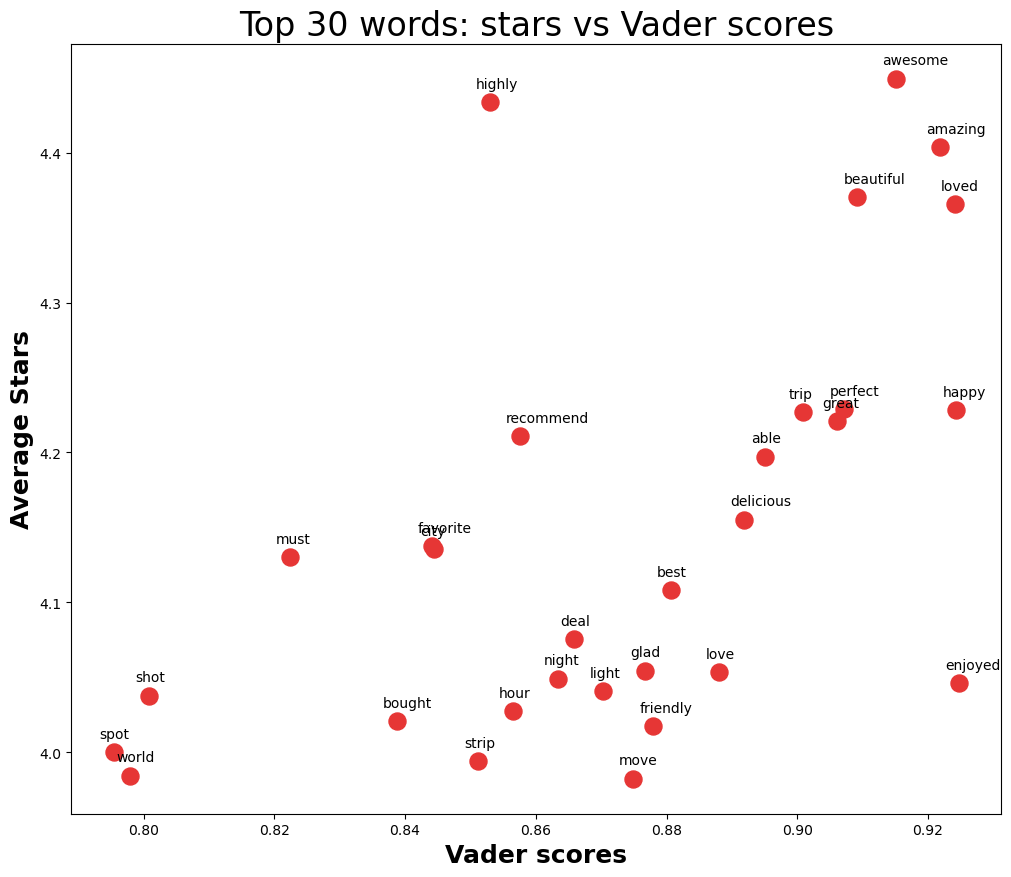

In [33]:
w1 = 30
ylp2_plot = ylp2_top.sort_values(by=['stars_mean'], ascending=False)[['word_', 'Vader_score_mean','stars_mean']].head(w1)

#! Plot stars vs reviews
y = list(ylp2_plot.stars_mean.values)
x = list(ylp2_plot.Vader_score_mean.values)
n = list(ylp2_plot.word_.values)

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(x, y, color=pred, s=150)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]), xytext=(-10,10), textcoords='offset points', ha='left')
v_title = "Top "+str(w1)+" words: stars vs Vader scores"
plt.title(v_title, size=24)
plt.ylabel("Average Stars", size=18, fontweight='bold')
plt.xlabel("Vader scores", size=18, fontweight='bold')
plt.show()

There is a strong similiarity between the top 30 words average star rating vs AFFIN sentiment scores and Vader Sentiment Scores which further backs the previous insights that words “awesome”, “amazing”, “great”, "loved","highly", “beautiful”, “happy” or “perfect” are more likely to be found in positive reviews, as indicated by the high average star rating.

Next, you can colour-code the words based on a set cut-off value (such as the average sentiment score, with any words with sentiment scores below the average appearing as red and any words with sentiment scores above the average appearing in blue). The following lines of code achieve this using the AFINN lexicon. 

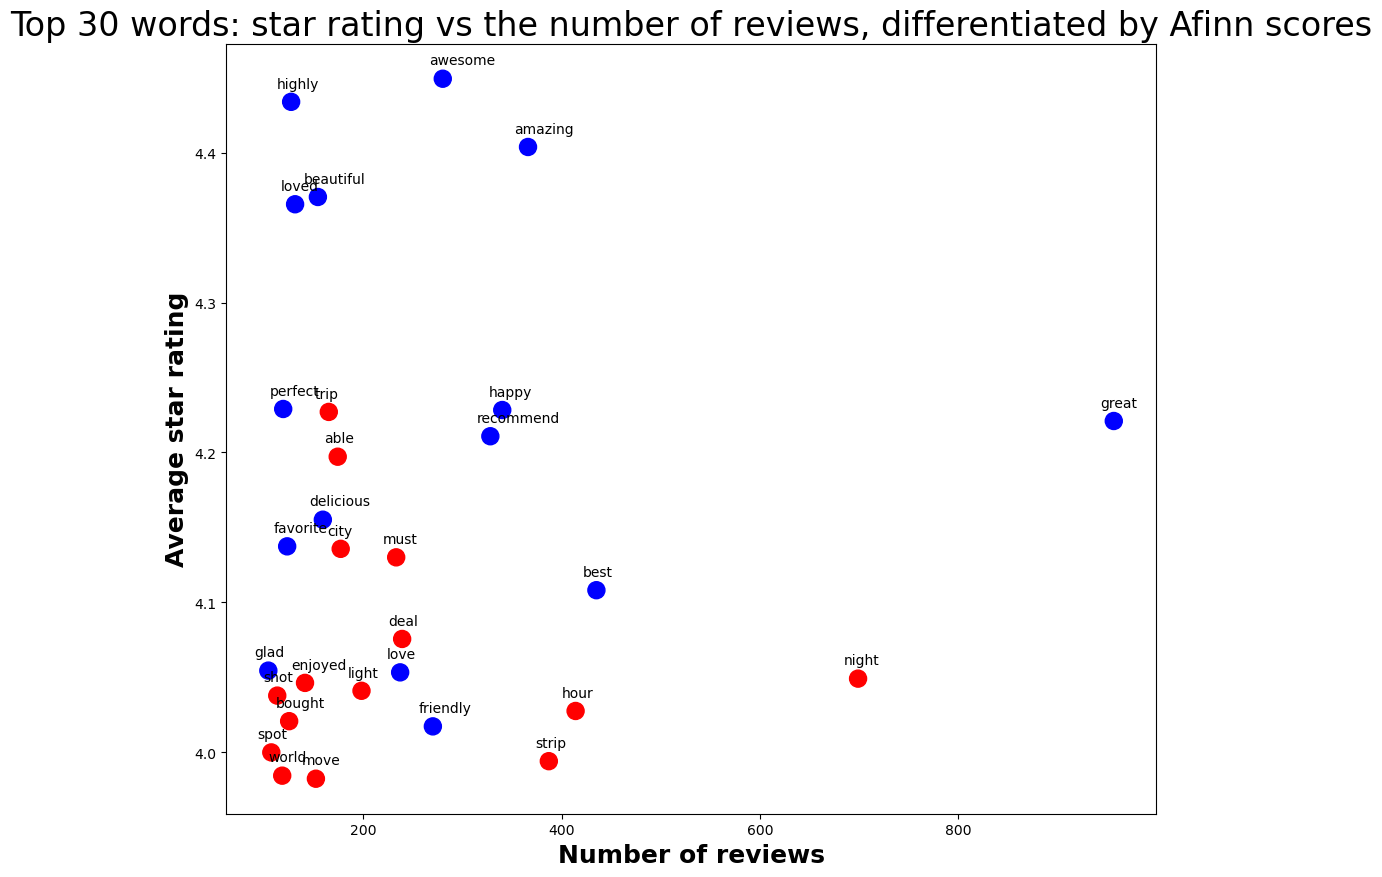

In [34]:
w1 = 30
ylp2_plot = ylp2_top.sort_values(by=['stars_mean'], ascending=False)[['word_', 'review_id_nunique', 'Afinn_score_mean', 'stars_mean']].head(w1)

v_cutoff = ylp2_plot.Afinn_score_mean.describe()[1]  ## here using the mean
colors = np.where(ylp2_plot["Afinn_score_mean"]>=v_cutoff,'b','r')

# Blue means better than average Affin score and Red otherwise

# Plot stars vs reviews.

y = list(ylp2_plot.stars_mean.values)
x = list(ylp2_plot.review_id_nunique.values)
n = list(ylp2_plot.word_.values)

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(x, y, c=colors, s=150)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]), xytext=(-10,10), textcoords='offset points', ha='left')
v_title = "Top "+str(w1)+" words: star rating vs the number of reviews, differentiated by Afinn scores"
plt.title(v_title, size=24)
plt.ylabel("Average star rating", size=18, fontweight='bold')
plt.xlabel("Number of reviews", size=18, fontweight='bold')
plt.show()

I could identify how often words appear in customer reviews, with words like “great” appearing in over 800 reviews, “awesome” appearing in over 250 reviews, and “amazing” appearing in over 300 reviews. However, more importantly, I could identify which words are strongly associated with positive customer sentiment, with the blue dots representing words with a higher average AFINN score. I noticed that customer reviews containing the words “awesome”, “amazing”, “great”, “beautiful”, “happy” or “perfect” are more likely to be found in positive reviews, as indicated by the high average star rating. 
In disparity, words that are strongly associated with lower AFINN scores or negative customer sentiment, such as “hour” and “night”, in red dots although not necessarily negative words, reveal potential weaknesses of the restaurants. It can be linked to unfavorable customer opinions; this may indicate that customers are not happy with how much time they spent at the establishment or with their entire experience at night. It may also indicate that a company is not offering a great experience if it is open late at night. This could be because of a variety of things, including inadequate lighting, excessive noise, or safety issues. It may also indicate that customers feel they are waiting too long or that the service is poor or inefficient. It could point to issues like understaffing, poor management, or other issues that increase wait times may be to blame for this. Consequently, managerial decisions can be made to enhance service efficiency and enhance the nighttime experience.
It's interesting to note that adjectives like "friendly," which don't necessarily refer to consumer attitudes, also stand up as advantageous qualities. It can point to the importance of delivering polite service to consumers, including hints about potential managerial choices. Satiate might concentrate on this to increase favorable ratings and customer satisfaction. 



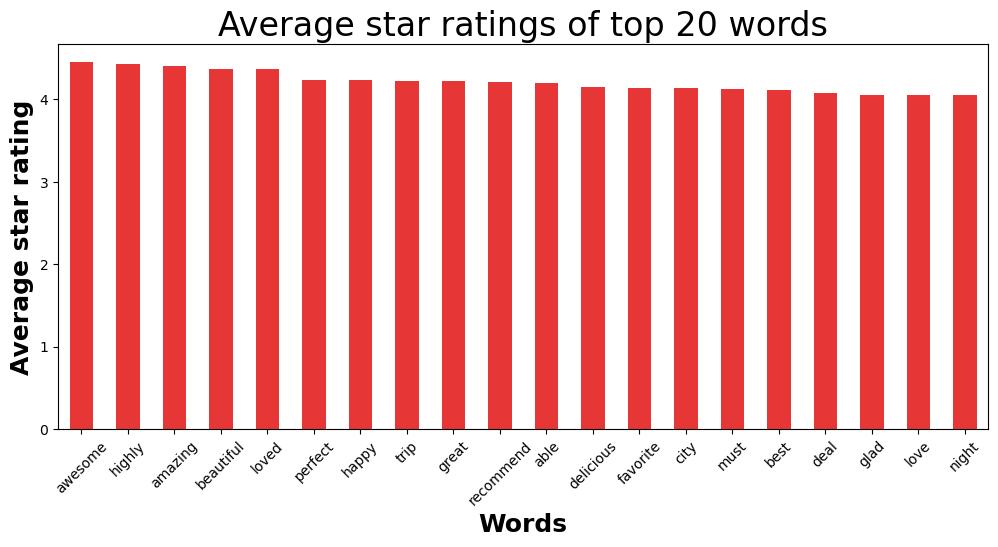

In [35]:
w1 = 20
t_plot = ylp2_top.sort_values(by=['stars_mean'], ascending=False)[['word_','stars_mean']].head(w1)
t_plot = t_plot.set_index('word_')
plt.figure(figsize=(12,5))
t_plot['stars_mean'].plot.bar(color=pred)
plt.xticks(rotation=45)
v_title = "Average star ratings of top "+str(w1)+" words"
plt.title(v_title, loc="center", fontsize=24)
plt.xlabel("Words", size=18, fontweight='bold')
plt.ylabel("Average star rating", size=18, fontweight='bold')
plt.show()

Alternatively, I can plot a set number of frequent words against the sum of the star ratings. Plotting the average star rating of the top 20 words involves calculating the average rating associated with each word. This approach provides an understanding of the sentiment or evaluation given by reviewers specifically for those words. It helps determine whether certain words are generally associated with positive or negative sentiments based on the average star ratings. As usual, words like "awesome", "highly", "amazing", "beautiful", "loved", "perfect" have the highest average ratings indicating positive sentiments and customer satisfaction.

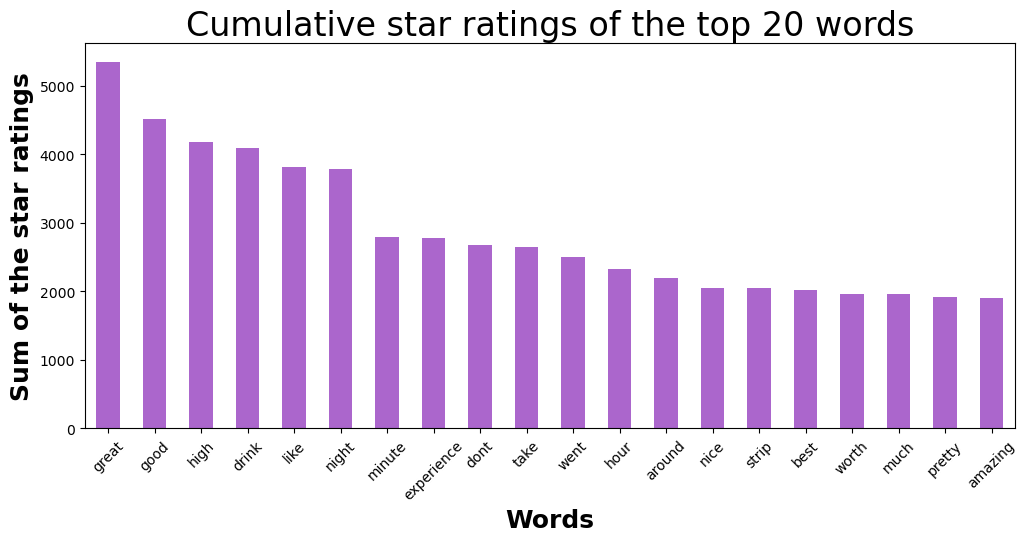

In [36]:
# Set number of top words to plot versus the sums of the star ratings.

w1 = 20
t_plot = ylp2_top.sort_values(by=['stars_sum'], ascending=False)[['word_','stars_sum']].head(w1)
t_plot = t_plot.set_index('word_')
plt.figure(figsize=(12,5))
t_plot['stars_sum'].plot.bar(color=purp)
plt.xticks(rotation=45)
v_title = "Cumulative star ratings of the top "+str(w1)+" words"
plt.title(v_title, loc="center", fontsize=24)
plt.xlabel("Words", size=18, fontweight='bold')
plt.ylabel("Sum of the star ratings", size=18, fontweight='bold')
plt.show()

On the other hand, plotting the cumulative star ratings of the top 20 words involves adding up the total star ratings across all reviews where those words appear. This approach emphasizes the overall impact or popularity of the words in terms of the star ratings. It shows the cumulative effect of those words on the overall ratings of the products or services being reviewed.

### What insights does plotting these two charts give?
Similarities:
Both plots include positive sentiment words such as "great," "good," "high," and "happy," indicating that customers generally have positive experiences with the business.
Both plots suggest that customers appreciate aspects like the quality of the products or services provided by the business.

Differences:
The cumulative star ratings plot emphasizes words like "drink," "night," and "minute," indicating that aspects related to drinks, nightlife, or timeliness have a significant impact on the overall ratings. This suggests that these aspects play a crucial role in shaping customers' opinions and evaluations of the business.
The average star ratings plot highlights words like "awesome," "amazing," "beautiful," and "perfect," which suggest that customers have extremely positive sentiments when using these terms. These words indicate a higher level of satisfaction and enthusiasm expressed by customers in their reviews.

Implications for the business:
The presence of words like "great," "good," and "happy" in both plots suggests that the business is generally providing a positive experience to its customers.
The prominence of words related to drinks, nightlife, or timeliness in the cumulative star ratings plot indicates that the business may have a strong focus on these aspects, which can significantly impact customer satisfaction and overall ratings.
The presence of highly positive and enthusiastic words in the average star ratings plot indicates that there are specific aspects or experiences that customers find truly exceptional. This suggests that the business has certain features or qualities that customers consider outstanding.
Overall, the similarities and differences between the cumulative star ratings and average star ratings plots provide insights into the key factors influencing customer sentiment and the aspects of the business that are particularly valued by customers. 
These patterns shows the business should focus on areas that contribute to positive experiences and customer satisfaction while addressing any potential areas for improvement.


You could also plot the number of times the most frequent words were found in unique reviews using the following lines of code.

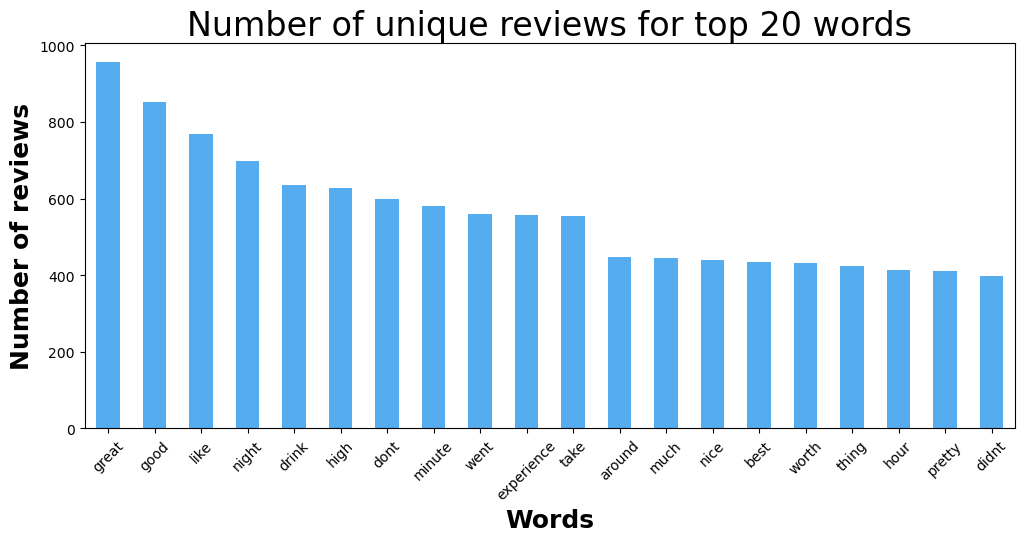

In [37]:
# Set number of top words to plot versus the number of reviews that those words appeared in.

w1 = 20
t_plot = ylp2_top.sort_values(by=['review_id_nunique'], ascending=False)[['word_','review_id_nunique']].head(w1)
t_plot = t_plot.set_index('word_')
plt.figure(figsize=(12,5))
t_plot['review_id_nunique'].plot.bar(color=blue)
plt.xticks(rotation=45)
v_title = "Number of unique reviews for top "+str(w1)+" words"
plt.title(v_title, loc="center", fontsize=24)
plt.xlabel("Words", size=18, fontweight='bold')
plt.ylabel("Number of reviews", size=18, fontweight='bold')
plt.show()

The information I can gleam from this chart is that the presence of these words among the top 20 words with the number of unique reviews indicates the popularity of certain aspects, the positive or neutral sentiment expressed by customers, and areas where the business can focus on improvement or customer engagement. Analyzing these patterns can help the business understand customer preferences, identify areas for enhancement, and address any potential concerns or issues to improve overall customer satisfaction.
The presence of words like "great," "good," "like," "night," "drink," "high," "don't," "minute," "went," and "experience" among the top 20 words with a high number of unique reviews suggests that these aspects or experiences are frequently mentioned by customers. This indicates that customers often have positive experiences, enjoy the nightlife or drinks, appreciate prompt service, and may have encountered both positive and negative experiences. The business should pay attention to these aspects and aim to maintain the positive aspects while addressing any issues raised by customers.

Finally, you could also plot the number of unique businesses that had reviews with the most frequently-used words, as achieved with the following lines of code.

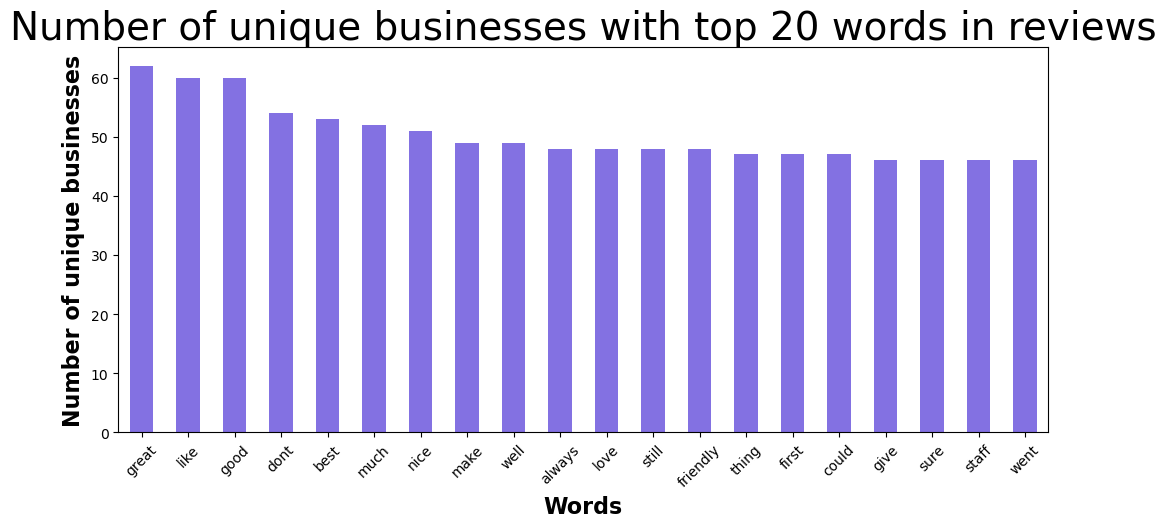

In [38]:
# Plot a set number of top words against number of businesses that had reviews with those words appearing in them.

w1 = 20
t_plot = ylp2_top.sort_values(by=['business_id_nunique'], ascending=False)[['word_','business_id_nunique']].head(w1)
t_plot = t_plot.set_index('word_')
plt.figure(figsize=(12,5))
t_plot['business_id_nunique'].plot.bar(color=amet)
plt.xticks(rotation=45)
v_title = "Number of unique businesses with top "+str(w1)+" words in reviews"
plt.title(v_title, loc="center", fontsize=28)
plt.xlabel("Words", size=16, fontweight='bold')
plt.ylabel("Number of unique businesses", size=16, fontweight='bold')
plt.show()

It can be deduced from this plot that the presence of words like "great," "like," "good," "don't," "best," "much," "nice," "make," "well," and "always" among the top 20 words with a high number of unique businesses in a sentiment analysis indicates that these are commonly mentioned aspects across multiple businesses. It suggests that customers appreciate these qualities in a business, such as great experiences, positive feelings, good service, and consistent performance. This is positive feedback for the businesses and highlights areas where they are doing well. It is important for the businesses to maintain these positive aspects and continue delivering excellent experiences to their customers.

# 12. Identifying relationships with regression plots

Finally, to conclude my sentiment analysis, I will create scatter plots with fitted regression lines to help clarify the relationship between variables of interest. For example, the following lines of code assess the relationship between the AFINN sentiment scores and star ratings. 

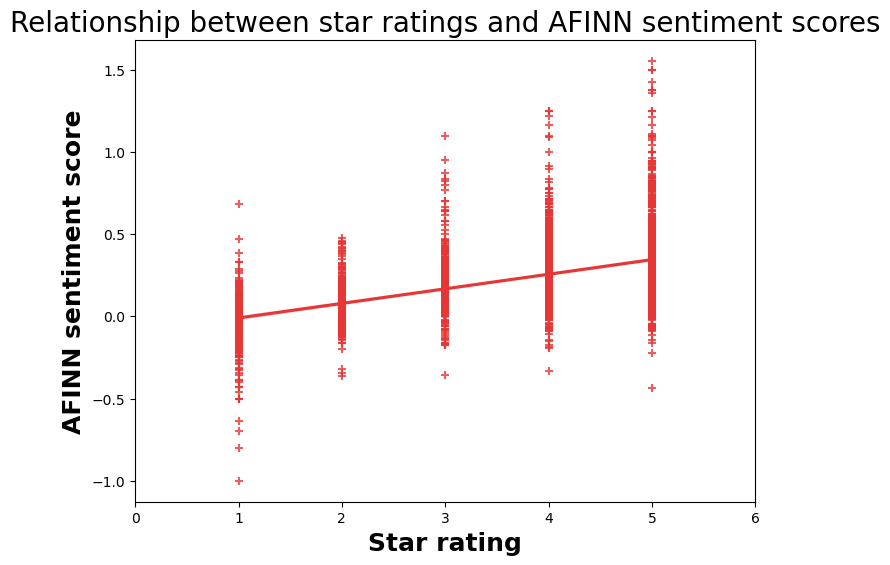

In [39]:
# This is a plot of the AFINN sentiment scores versus 1-5 star ratings, with a regression line fitted to the data.
ax = plt.figure(figsize=(8,6))
ax = sns.regplot(x="stars", y="lx1_avg_rev_score", data=ylp1, marker="+", color=pred )
ax.set_xticks([0,1,2,3,4,5,6])
plt.title('Relationship between star ratings and AFINN sentiment scores', size=20)
plt.xlabel('Star rating', size=18, fontweight='bold')
plt.ylabel('AFINN sentiment score', size=18, fontweight='bold')
plt.show()

From this plot, the relationship shows an upward slope, it indicates a positive correlation between the two variables. In other words, as the star rating increases, the sentiment score also tends to increase, suggesting a higher level of positive sentiment associated with higher star ratings. This relationship implies that customers who give higher star ratings are more likely to express positive sentiment in their reviews. It suggests that their experiences or perceptions of the product, service, or business are generally positive and align with the higher ratings they provide.


You can do the same analyses with the sentiment scores derived from the altenrative dictionary (i.e. the Vader lexicon), using the following lines of code.

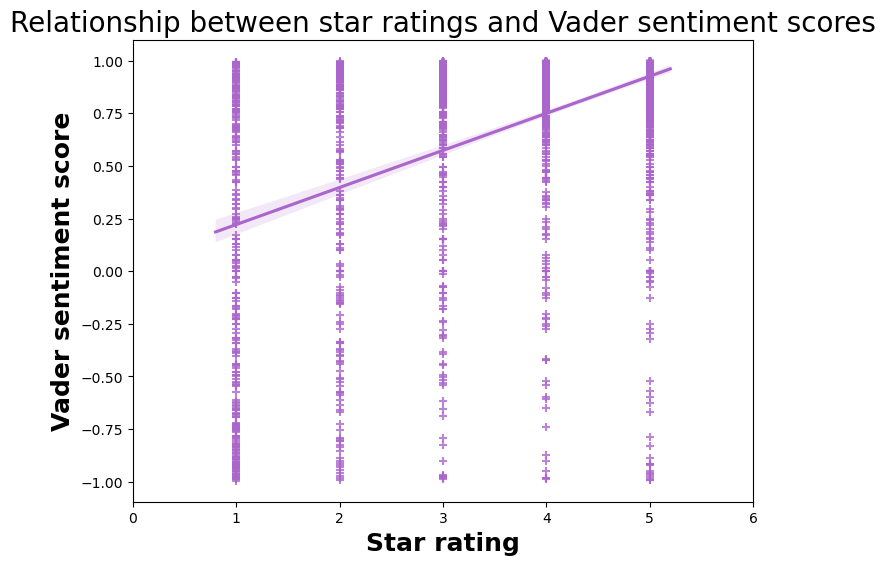

In [40]:
# This is a plot of the Vader sentiment scores versus 1-5 star ratings, with a regression line fitted to the data.
ax = plt.figure(figsize=(8,6))
ax = sns.regplot(x="stars", y="lx2_review_score", data=ylp1, marker="+", color=purp, ci=95, truncate=False )
ax.set_xticks([0,1,2,3,4,5,6])
plt.title('Relationship between star ratings and Vader sentiment scores', size=20)
plt.xlabel('Star rating', size=18, fontweight='bold')
plt.ylabel('Vader sentiment score', size=18, fontweight='bold')
plt.show()

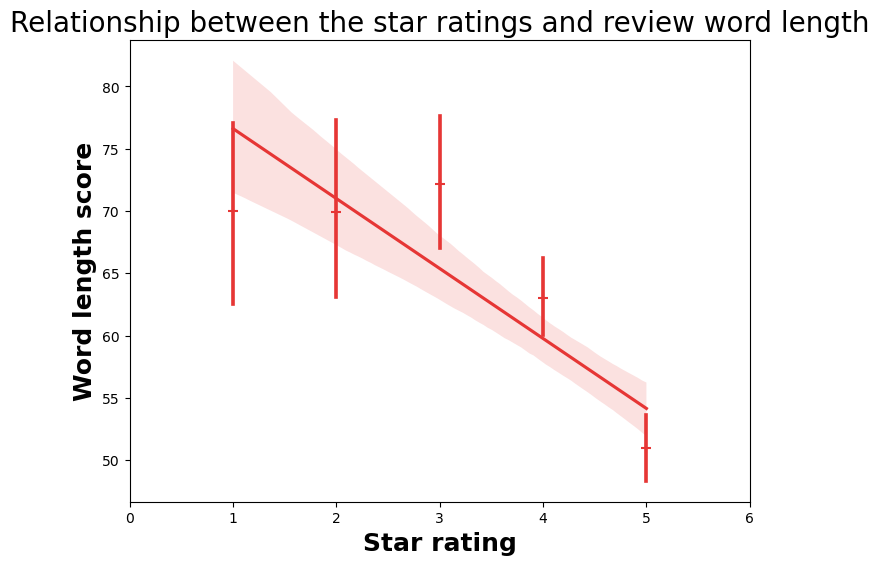

In [44]:
# This is a plot of the review word length versus 1-5 star ratings, with a regression line fitted to the data.
ax = plt.figure(figsize=(8,6))
ax = sns.regplot(x="stars", y="wordlen", data=ylp1, marker="+", color=pred, x_estimator=np.mean )
ax.set_xticks([0,1,2,3,4,5,6])
plt.title('Relationship between the star ratings and review word length', size=20)
plt.xlabel('Star rating', size=18, fontweight='bold')
plt.ylabel('Word length score', size=18, fontweight='bold')
plt.show()

This graph tells us that While there are some non-linearities (such as at the 3-star level), it seems that 5-star reviews tend to be shorter than 1-star reviews. In other words, the shorter the review, the more positive they tend to be.Also, it indicates that the longer the review, the more likely its a complaint.

Note that this relationship is true for this data set, but don't assume this to always be the case. Check what is empirically true for your data set.